# Исследования рынка общепита в Москве для принятия решения об открытии нового заведения

В рамках проекта необходимо открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы.<br>
Необходимо участие инвесторов, которых интересует текущее положение дел на рынке — сможет ли кафе снискать популярность на долгое время, когда все посетители насмотрятся на роботов-официантов?

Проект основан на открытых данных о заведениях общественного питания в Москве.

Выполнен в следующем порядке:
1. [Загрузка данных и подготовка к анализу](#start)
2. [Анализ данных](#analysis)
    * [Cоотношение видов объектов общественного питания по количеству](#2.1)
    * [Cоотношение сетевых и несетевых заведений по количеству](#2.2)
    * [Для какого вида объекта общественного питания характерно сетевое распространение?](#2.3)
    * [Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?](#2.4)
    * [Cреднее количество посадочных мест для каждого вида объекта общественного питания. Какой вид предоставляет в среднем самое большое количество посадочных мест?](#2.5)
    * [Информация об улице из столбца address](#2.6)
    * [Топ-10 улиц по количеству объектов общественного питания. В каких районах Москвы находятся эти улицы?](#2.7)
    * [Число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?](#2.8)
    * [Закономерности распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#2.9)
3. [Вывод](#conclusion)

<a id="start"></a>
## 1. Загрузка данных и подготовка к анализу

<font color=grey>Проверка типов данных, пропущенных значений и дубликатов</font>

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import date
from scipy import stats as st
import seaborn as sns
import scipy.stats as stats
import requests
import json
from bs4 import BeautifulSoup

#импорт необходимых библиотек

In [2]:
#path = 'C://Users//79313//8//'
path = '/datasets/'
data = pd.read_csv(path + 'rest_data.csv')

In [3]:
display(data.head())

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Описание данных в таблице:
<ul>
 <li>id — идентификатор объекта;</li>
 <li>object_name — название объекта общественного питания;</li>
 <li>chain — сетевой ресторан;</li>
 <li>object_type — тип объекта общественного питания;</li>
 <li>address — адрес;</li>
 <li>number — количество посадочных мест.</li>
</ul>

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Типы данных по столбцам корректные, пропусков нет.

In [5]:
sorted(data['object_type'].unique()) #вывод списка типов объектов

['бар',
 'буфет',
 'закусочная',
 'кафе',
 'кафетерий',
 'магазин (отдел кулинарии)',
 'предприятие быстрого обслуживания',
 'ресторан',
 'столовая']

In [6]:
sorted(data['chain'].unique()) #вывод списка принадлежности к сети

['да', 'нет']

In [7]:
data = data.applymap(lambda s:s.lower() if type(s) == str else s) #приведение всех текстовых данных к нижнему регистру

Приводим все текстовые данные к нижнему регистру для дальнейшей корректной работы.

In [8]:
data['object_name'] = data['object_name'].str.replace("«", "").str.strip()
data['object_name'] = data['object_name'].str.replace("»", "").str.strip()

Удаляем символы кавычек в названиях заведений.

In [9]:
print('Всего дубликатов:',data.duplicated().sum()) #проверка количества дубликатов

Всего дубликатов: 0


Полных дубликатов нет.

In [10]:
print('Всего дубликатов:',data[['object_name','address','object_type']].duplicated().sum()) #проверка количества дубликатов

Всего дубликатов: 185


После расширенной проверки выявлены дубликаты.<br>
Расширенная проверка проводилась по следующим критериям: в одном адресе не могут распологаться заведения с одинаковым именем и типом объекта.

In [11]:
data = data.drop_duplicates(subset=['object_name','address','object_type'])

Удаляем дубликаты данных.

In [12]:
data['number'].describe()

count    15181.000000
mean        59.922074
std         74.982762
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

В столбце с количеством посадочных мест есть элементы с нулевым значением.

In [13]:
print('Количество элементов с нулевым значением:',data.query('number==0')['number'].count())

Количество элементов с нулевым значением: 1583


При анализе информации, которая касается количества посадочных мест необходимо учитывать эту особенность.

In [14]:
data.query('number==0').groupby('object_type')['id'].count().reset_index()

,object_type,id
0,бар,28
1,буфет,64
2,закусочная,181
3,кафе,304
4,кафетерий,110
5,магазин (отдел кулинарии),144
6,предприятие быстрого обслуживания,689
7,ресторан,44
8,столовая,19


Принимаем допущение, что без посадочных мест могут быть только заведения: закусочная, магазин (отдел кулинарии), предприятие быстрого обслуживания.

In [15]:
data_clear = data.query('number!=0 or (number==0 and(object_type=="закусочная"\
                        or object_type=="магазин (отдел кулинарии)" or object_type=="предприятие быстрого обслуживания"))')

Формируем датасет, из которого исключаем заведения с нулевым количеством посадочных мест, которые не соответствуют ранее определённым параметрам (закусочная, магазин (отдел кулинарии), предприятие быстрого обслуживания).

In [16]:
data_clear.query('number==0').groupby('object_type')['id'].count().reset_index()

,object_type,id
0,закусочная,181
1,магазин (отдел кулинарии),144
2,предприятие быстрого обслуживания,689


<a id="analysis"></a>
## 2. Анализ данных

<a id="2.1"></a>
### Cоотношение видов объектов общественного питания по количеству

In [17]:
type_quantity = data.groupby('object_type')['id'].count().reset_index()

Формируем таблицу с данными.

In [18]:
print('Всего объектов общественного питания:', type_quantity['id'].sum())

Всего объектов общественного питания: 15181


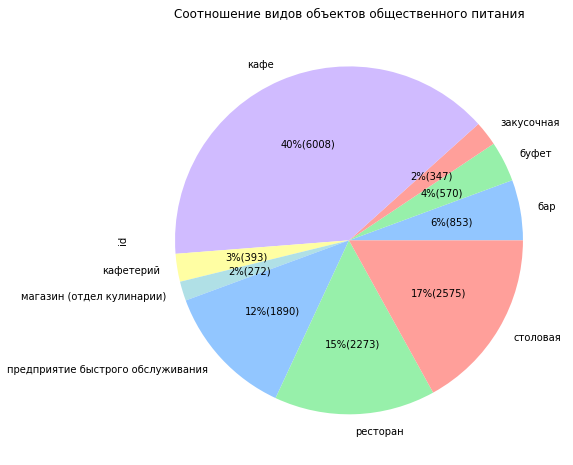

In [19]:
plt.style.use('seaborn-pastel')

type_quantity['id'].plot(figsize = (8,8), legend=False, title='Cоотношение видов объектов общественного питания',
        kind='pie', labels=type_quantity['object_type'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*type_quantity['id'].sum()));

Самый распространенный вид объекта в Москве - кафе.<br>
Также распространены рестораны, столовые и предприятия быстрого обслуживания (фаст фуд).<br>
Самый редкий тип объектов - закусочная, кафетерий, магазин (отдел кулинарии), бар и буфет.

<a id="2.2"></a>
### Cоотношение сетевых и несетевых заведений по количеству

In [20]:
data['chain'] = data['chain'].str.replace("да", "сетевые")
#заменяю значение на более понятное

In [21]:
chain_quantity = data.groupby('chain')['id'].count().reset_index()

Формируем таблицу с данными.

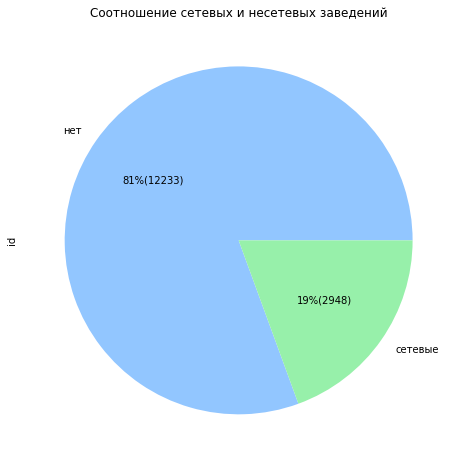

In [22]:
plt.style.use('seaborn-pastel')

chain_quantity['id'].plot(figsize = (8,8), legend=False, title='Cоотношение сетевых и несетевых заведений',
        kind='pie', labels=chain_quantity['chain'],
        autopct=lambda p: '{:.0f}%({:.0f})'.format(p,(p/100)*chain_quantity['id'].sum()));

Доля сетевых заведений составляет 19%, что является значимым результатом в структуре распределения.

<a id="2.3"></a>
### Для какого вида объекта общественного питания характерно сетевое распространение?

In [23]:
type_chain = data.pivot_table(index = 'object_type', columns='chain', values='id', aggfunc='count').reset_index()

Формируем таблицу с данными.

In [24]:
type_chain['%'] = (type_chain['сетевые']/(type_chain['сетевые']+type_chain['нет'])).apply('{:.0%}'.format)
#добавляю столбец с процентным соотношением
display(type_chain)

chain,object_type,нет,сетевые,%
0,бар,816,37,4%
1,буфет,559,11,2%
2,закусочная,291,56,16%
3,кафе,4621,1387,23%
4,кафетерий,342,51,13%
5,магазин (отдел кулинарии),194,78,29%
6,предприятие быстрого обслуживания,1106,784,41%
7,ресторан,1732,541,24%
8,столовая,2572,3,0%


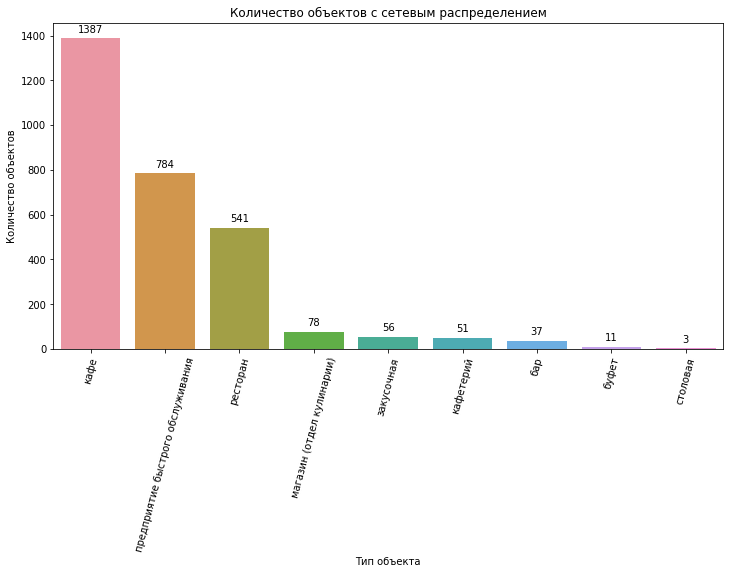

In [25]:
fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(12) # ширина

test.set_title('Количество объектов с сетевым распределением')
ax=sns.barplot(x="object_type", y="сетевые", data=type_chain.sort_values(by='сетевые', ascending=False))
test.set_ylabel('Количество объектов')
test.set_xlabel('Тип объекта')
ax.set_xticklabels(ax.get_xticklabels(),rotation=75);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

В количественном выражении больше всего сетевых объектов представлены в виде кафе, предприятий быстрого обслуживания и ресторанов.


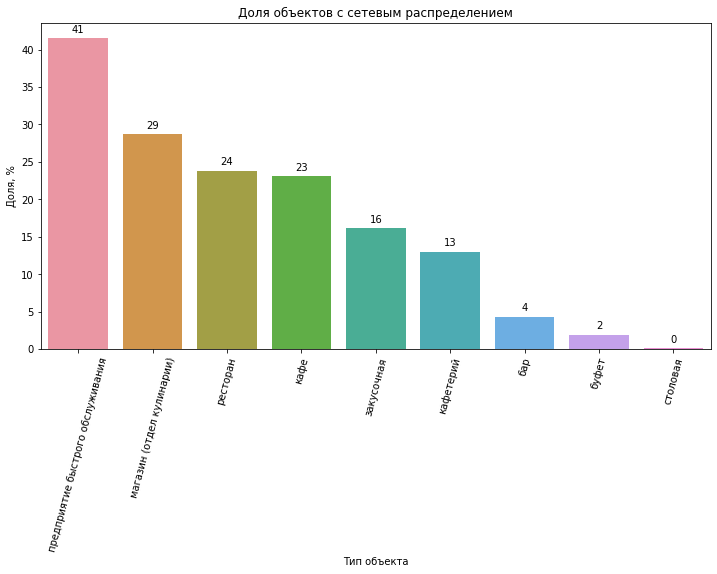

In [26]:
type_chain['share'] = (type_chain['сетевые']/(type_chain['сетевые']+type_chain['нет']))*100
fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(12) # ширина

test.set_title('Доля объектов с сетевым распределением')
ax=sns.barplot(x="object_type", y="share", data=type_chain.sort_values(by='share', ascending=False))
test.set_ylabel('Доля, %')
test.set_xlabel('Тип объекта')
ax.set_xticklabels(ax.get_xticklabels(),rotation=75);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

В доле от общего количества объектов того же типа сетевое распространение характерно для предприятий быстрого обслуживания.<br>
Также отчасти характерно для магазинов(отделов кулинарии).<br>
Меньше всего сетевых заведений среди столовых, баров и буфетов, что коррелирует с общими показателями распределения по типам объектов.<br>

<a id="2.4"></a>
### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

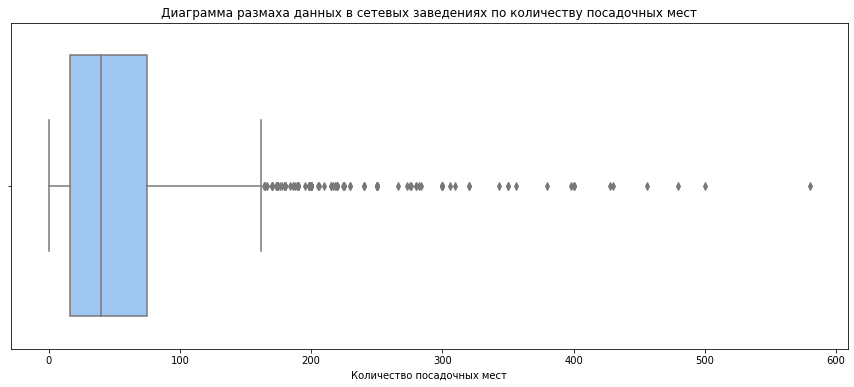

In [27]:
fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(15) # ширина
sns.boxplot(x=data_clear.query('chain=="да"')['number'])
test.set_title('Диаграмма размаха данных в сетевых заведениях по количеству посадочных мест')
test.set_xlabel('Количество посадочных мест');

Определяю границу выбросов в 180 посадочных мест.

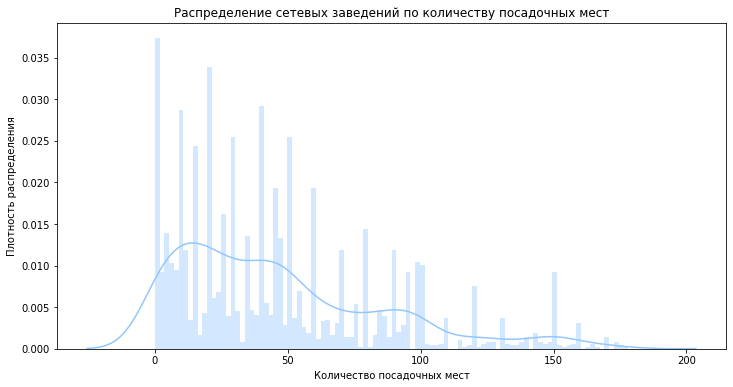

In [28]:
fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(12) # ширина
sns.distplot(data_clear.query('chain=="да" and number<180')['number'], bins=100)
test.set_title('Распределение сетевых заведений по количеству посадочных мест')
test.set_ylabel('Плотность распределения')
test.set_xlabel('Количество посадочных мест');

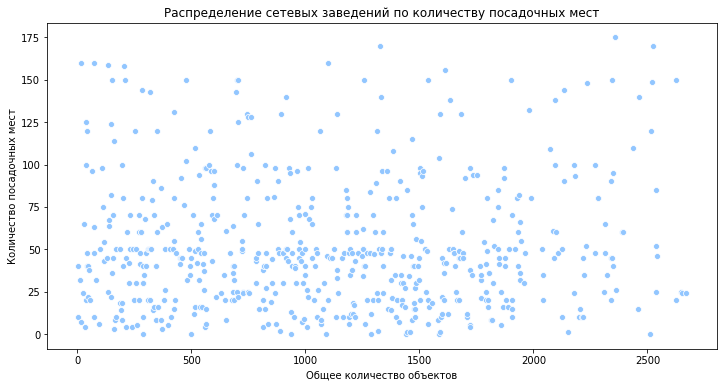

In [29]:
x_values = pd.Series(range(0,len(data_clear.query('chain=="да" and number<180')['number'])))
fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(12) # ширина
sns.scatterplot(x=x_values, y=data_clear.query('chain=="да" and number<180')['number'])
test.set_title('Распределение сетевых заведений по количеству посадочных мест')
test.set_ylabel('Количество посадочных мест')
test.set_xlabel('Общее количество объектов');

Для сетевых заведений характерно много заведений (до 50) с небольшим числом посадочных мест в каждом.<br>
Также существует доля заведений (примерно 1/3) с вместимостью от 50 до 100 мест.<br>
Сетевые заведения с вместимостью более 100 мест представлены редко.

<a id="2.5"></a>
### Cреднее количество посадочных мест для каждого вида объекта общественного питания. Какой вид предоставляет в среднем самое большое количество посадочных мест?

In [30]:
type_number = data_clear.groupby('object_type')['number'].mean().reset_index().sort_values(by='number', ascending=False)
type_number['number'] = type_number['number'].astype(int)

In [31]:
display(type_number)

,object_type,number
8,столовая,131
7,ресторан,99
1,буфет,58
0,бар,45
3,кафе,42
6,предприятие быстрого обслуживания,20
4,кафетерий,12
2,закусочная,7
5,магазин (отдел кулинарии),5


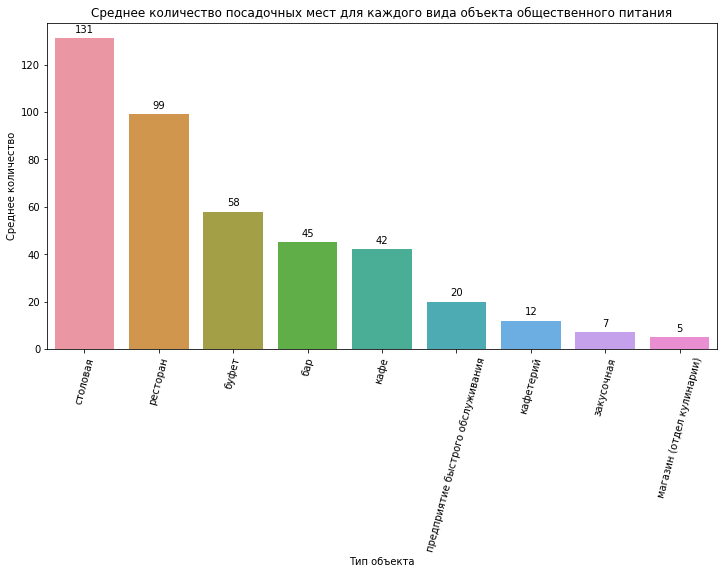

In [32]:
fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(12) # ширина

test.set_title('Cреднее количество посадочных мест для каждого вида объекта общественного питания')
ax=sns.barplot(x="object_type", y="number", data=type_number)
test.set_ylabel('Среднее количество')
test.set_xlabel('Тип объекта')
ax.set_xticklabels(ax.get_xticklabels(),rotation=75);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

В среднем больше всего посадочных мест предоставляют столовые и рестораны (100-130 мест).<br>
Буфеты, бары и кафе располагают 40-60 посадочными местами.<br>
Меньше всего посадочных мест в предприятиях быстрого обслуживания, кафетериях и закусочных (до 20 мест).

<a id="2.6"></a>
### Информация об улице из столбца address

In [33]:
streets_names = ['улица','проспект','шоссе','проезд',
                 'бульвар','переулок','набережная','площадь','вал','аллея']
 
def get_street(address):
    for position in [1,0,2]:
        for address_part in address.split(',')[position].split(' '):           
            if address_part in streets_names:
                street = address.split(', ')[position]
                return street

In [34]:
data['street'] = data['address'].apply(get_street)

In [35]:
pd.options.mode.chained_assignment = None  # default='warn'
data_clear['street'] = data_clear['address'].copy().apply(get_street)

С помощью функции формируем столбец с информацией о улице.

In [36]:
display(data.head(5))

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,кафе академия,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,сетевые,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,кафе вишневая метель,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица


<a id="2.7"></a>
### Топ-10 улиц по количеству объектов общественного питания. В каких районах Москвы находятся эти улицы?

In [37]:
top10_streets = data.groupby('street')['id'].count().reset_index().sort_values(by='id', ascending = False)
top10_streets.rename(columns={'id': 'quantity'}, inplace=True) 


Формируем таблицу с данными о количестве объектов общественного питания.

In [38]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [39]:
print(color.BOLD + 'Топ 10 улиц по количеству объектов общественного питания:'+ color.END)
display(top10_streets.head(10))

Топ 10 улиц по количеству объектов общественного питания:


,street,quantity
1055,проспект мира,196
1059,профсоюзная улица,181
684,ленинградский проспект,172
1010,пресненская набережная,165
400,варшавское шоссе,163
687,ленинский проспект,148
1051,проспект вернадского,126
675,кутузовский проспект,114
598,каширское шоссе,110
606,кировоградская улица,107


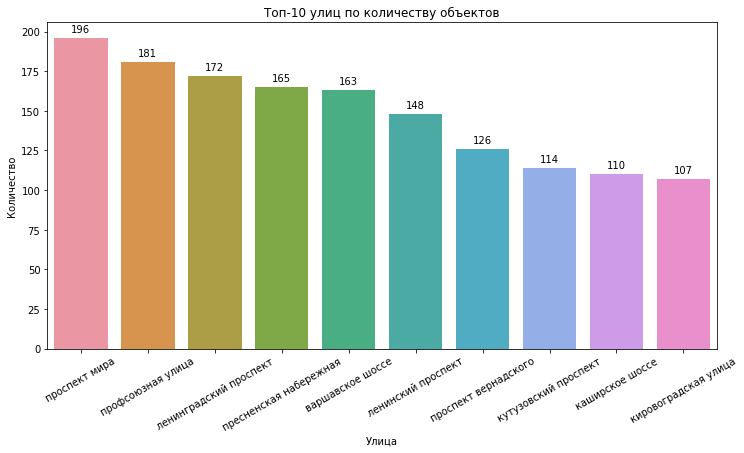

In [40]:
top10_streets=top10_streets.head(10)

fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(12) # ширина

test.set_title('Топ-10 улиц по количеству объектов')
ax=sns.barplot(x="street", y="quantity", data=top10_streets)
test.set_ylabel('Количество')
test.set_xlabel('Улица')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Улицы с максимальным количеством объектов: Проспект мира, Профсоюзная улица, Ленинградский проспект, Пресненская набережная, Варшавская шоссе.

In [41]:
street_list = top10_streets['street']

Формируем массив со список улиц топ-10

In [42]:
data_top_10 = data.query('street in @street_list')[['address', 'street']].reset_index()

Формируем датафрейм со списком адресов по улицам, входяших только в топ-10

In [43]:
data_top_10 = data_top_10.drop_duplicates(subset=['address'])

Удаляем дубликаты для более быстрой обработки.

In [44]:
def get_coords(address):
    try:
        plase = str(address) 
        URL = "https://geocode-maps.yandex.ru/1.x/?apikey=XXXXXXXXXXXXXXXXXXXXXX"
        params = {"geocode": plase, "format": "xml", 'results':"1"}
        response = requests.get(URL, params=params)
        soup = BeautifulSoup(response.text, 'lxml')
        coordinates = (soup.find('pos').text)
        return coordinates
    except:
        return 'none'

Создаём функцию для определения координат из запроса к API Яндекс.Геокодер по адресу.

Обращаемся к API Яндекс.Геокодер и формируем столбец с данными о координатах объектов.

Для ускорения времени проверки сохраняем полученный датафрейм и присваиваем ячейкам статус RAW NBConvert

In [45]:
from io import BytesIO
import requests
spreadsheet_id = '1bns92eGfx3znyjy7YQNth8bfFna7Z9pMEJNgvRNL8ac'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data_top_10 = pd.read_csv(BytesIO(r.content))

#https://docs.google.com/spreadsheets/d/1bns92eGfx3znyjy7YQNth8bfFna7Z9pMEJNgvRNL8ac/edit?usp=sharing

Для ускорения времени проверки загружаем датафрейм из таблиц Google.

In [46]:
len1 = len(data_top_10)
data_top_10 = data_top_10.query('coords!="none"')
print('Удалено строк:',len1-len(data_top_10))

Удалено строк: 1


Удаляем из датафрейма пустые занчения координат, полученные ранее в функции get_coords методом try/except

In [47]:
def get_district(coords):
    try:
        plase = str(coords)
        URL = "https://geocode-maps.yandex.ru/1.x/?apikey=35fe2038-052e-4de1-bb68-d25b4d84a692"
        params = {"geocode": plase, "format": "json", "kind": "district", "results":"1"}
        response = requests.get(URL, params=params)
        district_name = (json.loads(response.text)['response']['GeoObjectCollection']\
      ['featureMember'][0]['GeoObject']['metaDataProperty']['GeocoderMetaData']\
      ['AddressDetails']['Country']['AdministrativeArea'][ 'Locality']['DependentLocality']\
      ['DependentLocality']['DependentLocalityName'])
        return district_name
    except:
        return 'none'

Создаём функцию для определения района из запроса к API Яндекс.Геокодер по координатам.

Обращаемся к API Яндекс.Геокодер и формируем столбец с данными о районах на основании координат объектов.

Для ускорения времени проверки сохраняем полученный датафрейм и присваиваем ячейкам статус RAW NBConvert

In [48]:
spreadsheet_id = '1XxAgiRTUr-oYtwsijIdFIzyMiNg370JWEsST9pLs_Pk'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data_top_10 = pd.read_csv(BytesIO(r.content))

#https://docs.google.com/spreadsheets/d/1XxAgiRTUr-oYtwsijIdFIzyMiNg370JWEsST9pLs_Pk/edit?usp=sharing

Для ускорения времени проверки загружаем датафрейм из таблиц Google.

In [49]:
display(data_top_10.head())

,index,address,coords,district
0,151,"город москва, варшавское шоссе, дом 2",37.619683 55.699943,Донской район
1,152,"город москва, варшавское шоссе, дом 7, корпус 1",37.622405 55.700877,Донской район
2,153,"город москва, варшавское шоссе, дом 29",37.622432 55.693226,Донской район
3,154,"город москва, варшавское шоссе, дом 72, корпус 2",37.618758 55.656869,Нагорный район
4,155,"город москва, варшавское шоссе, дом 100",37.618812 55.646228,Нагорный район


In [50]:
data = data.merge(data_top_10[['address', 'coords', 'district']], on='address', how='left')

Добавляем в основной датасет data информацию о координатах и районе.

In [51]:
display(data.head())

,id,object_name,chain,object_type,address,number,street,coords,district
0,151635,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова,NaN,NaN
1,77874,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина,NaN,NaN
2,24309,кафе академия,нет,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица,NaN,NaN
3,21894,пиццетория,сетевые,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица,NaN,NaN
4,119365,кафе вишневая метель,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица,NaN,NaN


При этом в датасет загружаются координаты и район только для объектов, расположенных на топ-10 улиц.

In [52]:
top_district = data.query('street in @street_list')\
    [['address', 'street', 'district']].reset_index().groupby('district')\
    ['index'].count().reset_index().sort_values(by='index', ascending=False)
top_district.rename(columns={'index': 'quantity'}, inplace=True) 

Формируем датафрейм с количеством объектов, расположенных на топ-10 улиц, по районам города.

In [53]:
print(color.BOLD + 'Районы, в которых расположены топ-10 улиц с объектами общественного питания:'+ color.END)
display(top_district)

Районы, в которых расположены топ-10 улиц с объектами общественного питания:


,district,quantity
10,Пресненский район,165
30,район Чертаново Центральное,89
26,район Тропарёво-Никулино,83
13,район Аэропорт,64
8,Обручевский район,64
6,Мещанский район,63
15,район Дорогомилово,61
18,район Нагатино-Садовники,56
24,район Свиблово,56
28,район Фили-Давыдково,53


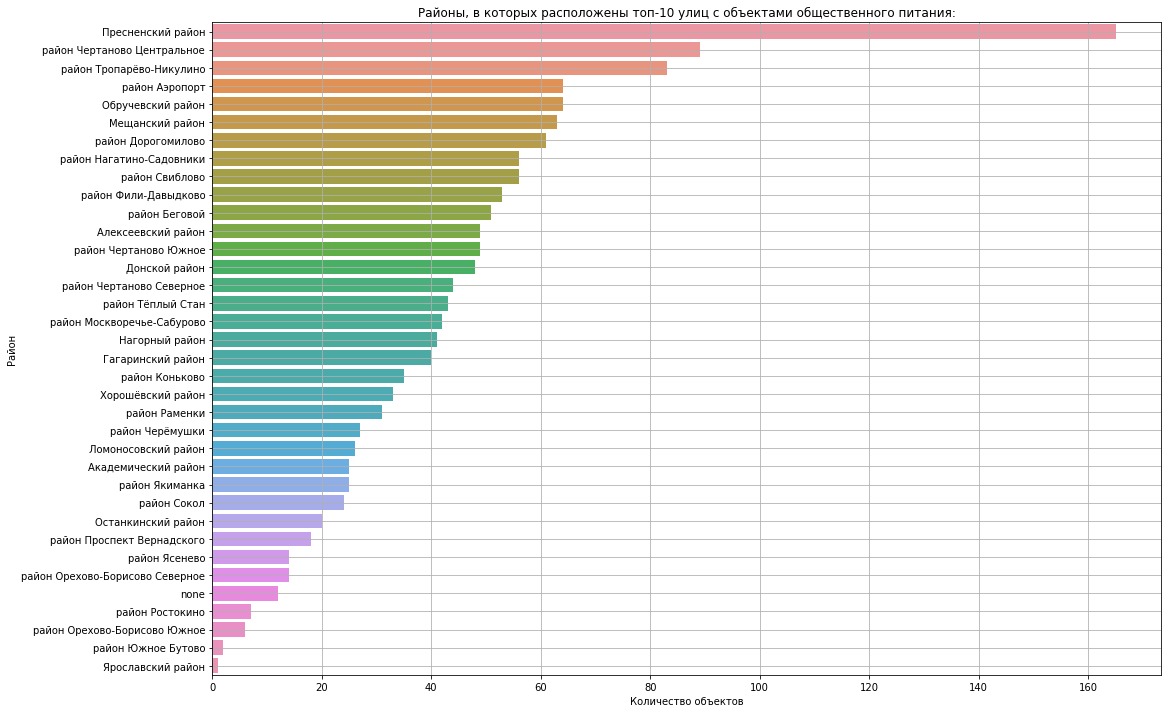

In [54]:
fig, test = plt.subplots()
fig.set_figheight(12) # высота 
fig.set_figwidth(17) # ширина

test.set_title('Районы, в которых расположены топ-10 улиц с объектами общественного питания:')
ax=sns.barplot(x="quantity", y="district", data=top_district)
test.set_ylabel('Район')
test.set_xlabel('Количество объектов')
ax.grid()
#ax.set_xticklabels(ax.get_xticklabels(),rotation=80);

Районы с улицами с максимальной концентрацией заведений: Пресненский, Чертаново-Центральное, Тропарёво-Никулино.

<a id="2.8"></a>
### Число улиц с одним объектом общественного питания. В каких районах Москвы находятся эти улицы?

In [55]:
one_streets = data.groupby('street')['id'].count().reset_index().sort_values(by='street')
one_streets.rename(columns={'id': 'quantity'}, inplace=True) 
one_streets = one_streets.query('quantity==1')

Формирую таблицу улиц с одним объектом общественного питяния.

In [56]:
print('Количество улиц с одним объектом общественного питания:', one_streets['quantity'].count())

Количество улиц с одним объектом общественного питания: 527


In [57]:
one_streets = one_streets.merge(data, on='street', how='left')
one_streets = one_streets[['street','address']]

Добавляем информацию об адресе в таблицу.

Обращаемся к API Яндекс.Геокодер и формируем столбец с данными о координатах объектов.

Для ускорения времени проверки сохраняем полученный датафрейм и присваиваем ячейкам статус RAW NBConvert

In [58]:
from io import BytesIO
import requests
spreadsheet_id = '1OPfIm11XS_bZ1qbCJLG767CN-ExTsSEavnnJESI1bls'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
one_streets = pd.read_csv(BytesIO(r.content))

#https://docs.google.com/spreadsheets/d/1OPfIm11XS_bZ1qbCJLG767CN-ExTsSEavnnJESI1bls/edit?usp=sharing

Для ускорения времени проверки загружаем датафрейм из таблиц Google.

Обращаемся к API Яндекс.Геокодер и формируем столбец с данными о районах на основании координат объектов.

In [59]:
data_top_10.to_csv(r'C:\Users\79313\8\1streets_distr.csv', sep='\t', index = False)

Для ускорения времени проверки сохраняем полученный датафрейм и присваиваем ячейкам статус RAW NBConvert

In [60]:
from io import BytesIO
import requests
spreadsheet_id = '1WFrJvYWt7aVxOC6zoP7265h53bo9ZKOtqbLWDZKPUyc'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
one_streets = pd.read_csv(BytesIO(r.content))

#https://docs.google.com/spreadsheets/d/1WFrJvYWt7aVxOC6zoP7265h53bo9ZKOtqbLWDZKPUyc/edit?usp=sharing

Для ускорения времени проверки загружаем датафрейм из таблиц Google.

In [61]:
display(one_streets.head())

,index,address,coords,district
0,151,"город москва, варшавское шоссе, дом 2",37.619683 55.699943,Донской район
1,152,"город москва, варшавское шоссе, дом 7, корпус 1",37.622405 55.700877,Донской район
2,153,"город москва, варшавское шоссе, дом 29",37.622432 55.693226,Донской район
3,154,"город москва, варшавское шоссе, дом 72, корпус 2",37.618758 55.656869,Нагорный район
4,155,"город москва, варшавское шоссе, дом 100",37.618812 55.646228,Нагорный район


In [62]:
one_district = one_streets.groupby('district')['index'].count().reset_index().sort_values(by='index', ascending=False)
one_district.rename(columns={'index': 'quantity'}, inplace=True)
one_district = one_district.query('district!="none"')

Формируем датафрейм с количеством объектов, расположенных на улицах с единственным заведением, по районам города.

In [63]:
print(color.BOLD + 'Районы, в которых расположены единственные объекты на улице:'+ color.END)
display(one_district.query('district!="none"'))

Районы, в которых расположены единственные объекты на улице:


,district,quantity
6,Мещанский район,45
26,район Тропарёво-Никулино,39
15,район Дорогомилово,29
31,район Чертаново Южное,28
14,район Беговой,27
17,район Москворечье-Сабурово,27
18,район Нагатино-Садовники,27
13,район Аэропорт,25
3,Гагаринский район,25
7,Нагорный район,22


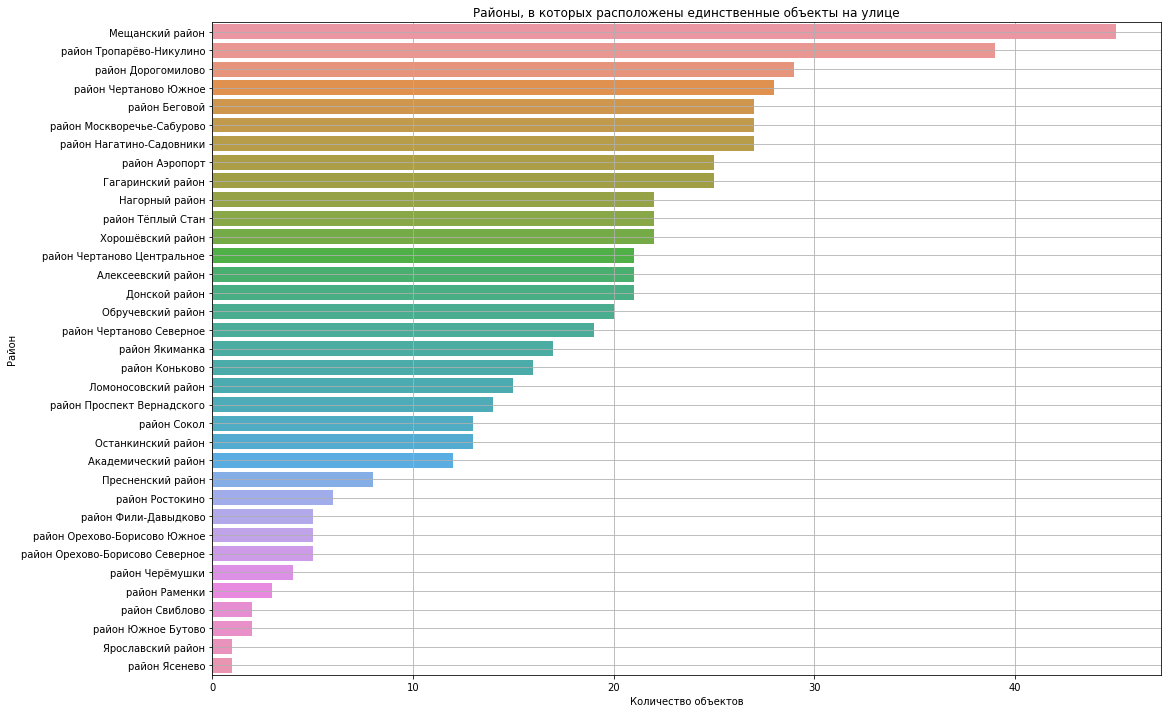

In [64]:
fig, test = plt.subplots()
fig.set_figheight(12) # высота 
fig.set_figwidth(17) # ширина

test.set_title('Районы, в которых расположены единственные объекты на улице')
ax=sns.barplot(x="quantity", y="district", data=one_district)
test.set_ylabel('Район')
test.set_xlabel('Количество объектов')
ax.grid()
#ax.set_xticklabels(ax.get_xticklabels(),rotation=80);

Районы, в которых расположены улицы с единственным объектом общественного питания с максимальным количеством заведений: Мещанский, Тропарёво-Никулино, Дорогомилово.

<a id="2.9"></a>
### Закономерности распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

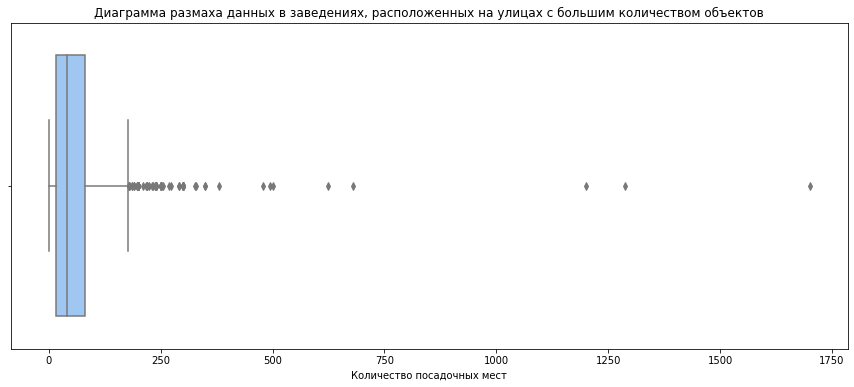

In [65]:
fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(15) # ширина
sns.boxplot(x=data_clear.query('street in @street_list')['number'])
test.set_title('Диаграмма размаха данных в заведениях, расположенных на улицах с большим количеством объектов')
test.set_xlabel('Количество посадочных мест');

Определяем границу выбросов в 200 посадочных мест.

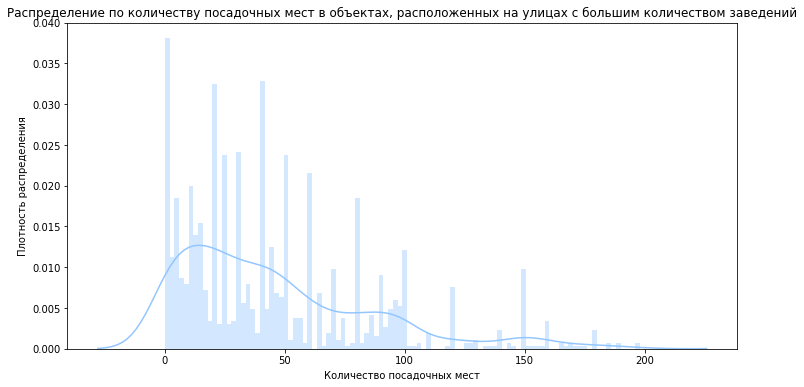

In [66]:
x_values = pd.Series(range(0,len(data_clear.query('street in @street_list and number<200')['number'])))

fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(12) # ширина
sns.distplot(data_clear.query('street in @street_list and number<200')['number'], bins=100)
test.set_title('Распределение по количеству посадочных мест в объектах, расположенных на улицах с большим количеством заведений')
test.set_ylabel('Плотность распределения')
test.set_xlabel('Количество посадочных мест');

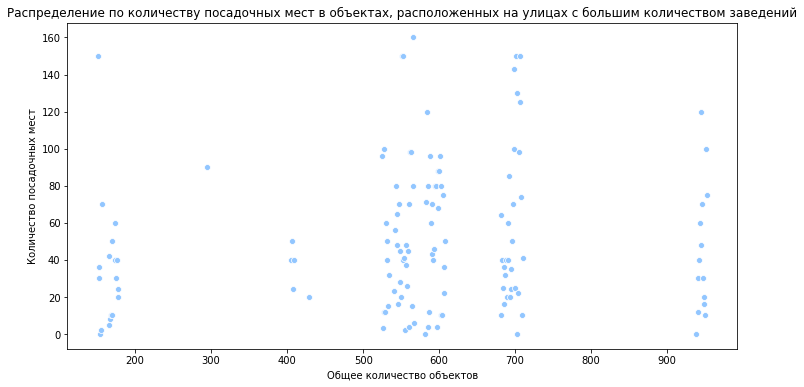

In [67]:
xx_values = pd.Series(range(0,len(data_clear.query('street in @street_list and number<200')['number'])))

fig, test = plt.subplots()
fig.set_figheight(6) # высота 
fig.set_figwidth(12) # ширина
sns.scatterplot(x=xx_values, y=data_clear.query('street in @street_list and number<200')['number'])
test.set_title('Распределение по количеству посадочных мест в объектах, расположенных на улицах с большим количеством заведений')
test.set_ylabel('Количество посадочных мест')
test.set_xlabel('Общее количество объектов');

Для объектов, расположенных на улицах с большим количеством заведений характерно до 50 посадочных мест.<br>
Также долю занимают объекты с 50-100 посадочными местами.

<a id="conclusion"></a>
## 3. Вывод

Сделайте общий вывод и дайте рекомендации о виде заведения, количестве посадочных мест, а также районе расположения. Прокомментируйте возможность развития сети.

<strong>Общие выводы:</strong>
* Самые распространенные виды объектов в Москве – кафе, ресторан, столовая;
* Сетевые заведения составляют 19% от общего числа объектов;
* В количественном выражении больше всего сетевых кафе, предприятий быстрого обслуживания и ресторанов, а в доле от объектов того же типа: предприятий быстрого обслуживания, магазинов (отделов кулинарии), ресторанов и кафе;
* Для сетевых заведений характерны залы до 50 посадочных мест. Залы более 100 посадочных мест встречаются редко;
* Для улиц с большим количеством заведений также характерны залы до 50 посадочных мест. Залы более 10 посадочных мест встречаются редко;
* Больше всего посадочных мест в среднем предоставляют столовые и рестораны (100-130 мест). Меньше всего (до 20) кафетерии и закусочные;
* Улицы с максимальным количеством объектов: Проспект мира, Профсоюзная улица, Ленинградский проспект;
* Районы, в которых расположен топ-10 улиц по числу заведений с максимальным количеством объектов: Пресненский, Чертаново-Центральное, Тропарёво-Никулино;
* В Москве 527 улиц с единственным объектом общественного питания;
* Районы, в которых расположены улицы с единственным заведением с максимальным количеством объектов: Мещанский, Тропарёво-Никулино, Дорогомилово.

<strong>Рекомендации:</strong>
* Тип объекта: кафе, на основании самого распространённого вида объектов в Москве и формата заведения (обслуживают роботы);
* Количество посадочных мест от 30 до 50 на основании статистики по среднему количеству посадочных мест по типу объектов кафе, а также статистики по распределению количества посадочных мест в сетевых объектах и объектах на улицах с максимальным числом заведений.
* Район расположения: Тропарёво-Никулино, Аэропорт, Мещанский район.Район выбирается по принципу: в районе находится улица из топ-10 по количеству заведений, в районе большое число объектов, в районе большое число улиц с единственным объектом. Таким образом можно занять локацию, которая с одной стороны подтверждает, что район популярен среди посетителей кафе, а с другой в районе потенциально есть место для открытия нового объекта.
* В Москве большое число сетевых кафе (1387), однако их доля в числе всех кафе составляет всего 23%. Таким образом перспективы развития сети кафе с роботами достаточно высоки, рынок не перенасыщен. Кроме того такое кафе при адаптации формата сможет конкурировать с предприятиями быстрого обслуживания, в которых доля сетевых объектов составляет 41% и которые представлены глобальными сетями.
